# Tutorial 06 – Anomaly detection

Anomaly detection is the task of finding suspicious data points in the dataset. There are multiple reasons why a data point may be suspicious (see slides of lecture 4). Another similar term to anomaly is outlier and both are very often used interchangeably. Formally, an anomaly is generated by a different mechanism than the rest of the data whereas an outlier is generated by the same mechanisms but is just far away from the rest of the data. Nevertheless, in any practical usecase, there is just no way of distinguishing between the two and we will use these terms interchangeably as well.

Anomalies are not necessarily a bad thing. They are just data points that do not follow typical pattern in the data. They can be actually very interesting. They can, for example, indicate a problem in your experiment design, a fraud in the stream of money transactions, or a new scientific discovery waiting to be understood. In either case, its worth spending some time investigating them instead of just throwing them away immediately.

There are two main use cases for anomaly detection.
1. Detecting outliers in the data as a part of preprocessing and data cleaning. In this case the outliers are often discarded from the training data so the model learns only the main data generating mechanisms.
2. Detecting anomalies as a standalone machine learning task. In this case we are especially interested in anything suspicious and it is out main interest, e.g., detecting frauds in cyber security. 

In this tutorial, we will look at both use cases. As always, you can read a bit more about outlier detection in [scikit-learn user guide](https://scikit-learn.org/stable/modules/outlier_detection.html#).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()  # make plots nicer

## Statistical Methods

### Univariate

First, we will look at statistical methods of detecting outliers. These methods rely on simple statistics and outliers are defined as values very unlikely to be generated given some distribution. We often do not know the exact distribution in advance just the family, e.g., normal distribution. The distribution parameters need to be estimated from the data itself.

Methods below are only used for univariate normal distributions, but you could use IQR for other distributions with various degree of success. Let's start simple and generate some data from normal distribution.

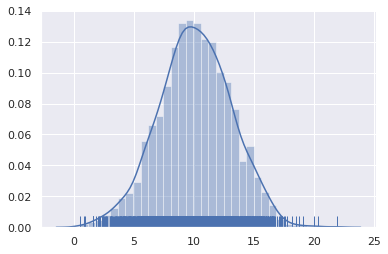

In [2]:
np.random.seed(1)
data = np.random.normal(10, 3, 2000)
data = data.round(2)
sns.distplot(data, rug=True)

<div class="alert alert-block alert-warning"><b>Exercise 1</b></div>

Find outliers in the `data`. We will define outliers as data points that are more than 3 standard deviations from the mean of the data. 

You should identify the following outliers with this method. 
$$0.54, 0.84, 0.95, 19.96, 20.3, 21.88$$

In [5]:
# TODO: your code goes here...
outliers = data[np.abs(data - np.mean(data)) > 3 * np.std(data)]
print(outliers)

[21.88 19.96  0.84  0.54  0.95 20.3 ]


A common method of visualizing the data distribution is a box plot. Let's plot a box plot of our `data`.

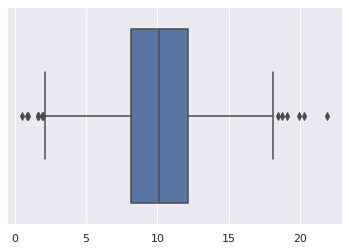

In [6]:
sns.boxplot(data)

These box plots often show outlier values that are outside the 'whiskers'. Such points are more than 1.5 inter quartile ranges away from the lower and upper quartile.

<div class="alert alert-block alert-warning"><b>Exercise 2</b></div>

Find outliers in `data` using inter quartile range (IQR). The IQR is defined as $IQR = (Q_3 - Q_1)$ where $Q_3$ and $Q_1$ are third and first quartiles. The outliers are data points **outside** the range $[Q_1 - 1.5 \cdot IQR,Q_3 + 1.5 \cdot IQR]$.

You should identify the following outliers using IQR method. 
$$0.54, 0.84, 0.95, 1.62, 1.63, 1.63, 1.65, 1.9, 2.01, 18.48, 18.75, 19.09, 19.96, 20.3, 21.88$$

In [9]:
# TODO: your code goes here...
q1 = np.quantile(data, 0.25)
q3 = np.quantile(data, 0.75)
iqr = q3 - q1
outliers = data[(data < np.abs(q1 - 1.5 * iqr)) | (data > np.abs(q3 + 1.5 * iqr))]
print(outliers)

[ 1.62 19.09  1.65 21.88  1.63 19.96  1.9   0.84  2.01 18.75 18.48  0.54
  0.95 20.3   1.63]


These two methods are doing very similar thing as can be seen from Figure 7 in [this Wikipedia page](https://en.wikipedia.org/wiki/Box_plot#Visualization). The whiskers for normal distribution are 2.698 standard deviations away from the mean.

Let's up the ante and do some proper statistical test. We will implement Grubbs's test for outliers. This test works **only** on normally distributed data. The test can be described as follows.
1. Compute test statistic $Z$ for each data point $x$ defined as $Z = \frac{|x - \mu|}{\sigma}$ where $\mu$ is sample mean and $\sigma$ is sample standard deviation.
2. Compute critical value for the Z statistics defined as $$ \frac{N-1}{\sqrt{N}} \sqrt{\frac{(t_{\alpha/(2N), N-2})^2}{N-2+t_{\alpha/(2N), N-2})^2}} $$ where $t$ are quantiles of student T distribution and $N$ is the number of data points.
3. Test each data point and if its $Z$ statistic is bigger than critical $Z$ value, it is an outlier.

To make your life easier, bellow is the function that computes critical value of $Z$ and does the 'heavy lifting' for you.

In [12]:
from scipy.stats import t


def get_critical_Z(N, alpha=0.05):
    t_quantile = t.ppf(alpha / (2 * N), N - 2) ** 2
    return (N - 1) / np.sqrt(N) * np.sqrt(t_quantile / (N - 2 + t_quantile))

<div class="alert alert-block alert-warning"><b>Exercise 3</b></div>

Your task is to implement steps 1. a 3. of Grubbs' test and apply the test to `data`. Write a function that takes numpy array with data, computes $Z$ statistic for each data point, calls `get_critical_Z` function, and returns all data points that failed the outlier test.

There should be no data point from `data` identified as outlier.

In [14]:
def grubbs_outliers(data):
    pass
    # TODO: your code goes here...
    Z = np.abs(data - np.mean(data)) / np.std(data, ddof=1)
    critical_Z = get_critical_Z(data.shape[0])
    return data[critical_Z < Z]


grubbs_outliers(data)

array([], dtype=float64)

The problem with most statistical approaches, including all above, is that they compute the statistics from data including the outliers. We will demonstrate why it is the problem using the following examples.

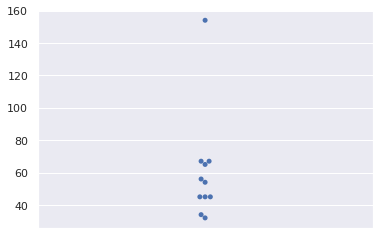

In [15]:
data_with_outlier = np.array([45, 56, 54, 34, 32, 45, 67, 45, 67, 65, 154])
sns.swarmplot(data_with_outlier, orient="v")

Here we have some data with one outlier (value 154). When we apply the Grubbs' test the outlier is correctly identified.

In [16]:
grubbs_outliers(data_with_outlier)

array([154])

Let's add second outlier with the very same value.

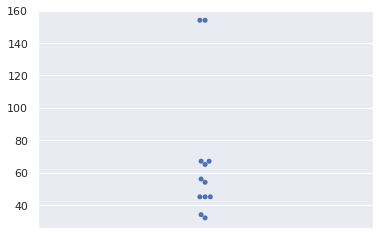

In [17]:
data_with_two_outliers = np.array([45, 56, 54, 34, 32, 45, 67, 45, 67, 65, 154, 154])
sns.swarmplot(data_with_two_outliers, orient="v")

In [18]:
grubbs_outliers(data_with_two_outliers)

array([], dtype=int64)

Adding the second outlier have distorted the distribution too much. The mean and standard deviation have changed such that the outlier, so called, masked themselves. You can read a bit more about masking in [Data mining and knowledge discovery handbook](http://www.eng.tau.ac.il/~bengal/outlier.pdf) or [the article we took the examples from](https://www.graphpad.com/support/faq/masking-in-outlier-detection-why-it-can-be-harder-to-detect-two-outliers-than-one/).

### Multivariate

Detecting outliers using statistics in multivariate data can be done using Gaussian Mixture Models. We used GMM in the previous tutorial for clustering. For outlier detection, you fit GMM model and then set a threshold. Data points having probability of being generated using your GMM below the set threshold are considered outliers.

## Density Based Methods

Now we will look at density based outlier detection methods, specifically Local Outlier Factor (LOF). For this, we will use data about diabetes among women from Pima Indian tribe. The full description of the data is in the paper [Using the ADAP learning algorithm to forecast the onset of diabetes mellitus](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2245318/pdf/procascamc00018-0276.pdf). Let's load the dataset.

In [19]:
diabetes = pd.read_csv("https://www.fi.muni.cz/~xcechak1/IB031/datasets/diabetes.csv")
diabetes.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

This data contains few physical measurements and then the columns `Outcome` states whether the woman has developed a diabetes in the next 5 years. We would like to see if there are any outliers possibly hinting at some other significant trait in predicting diabetes. First lets look at the individual features.

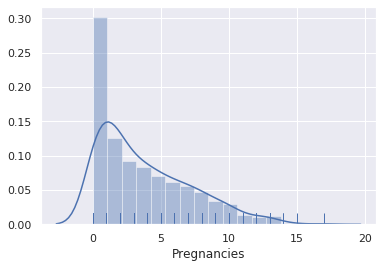

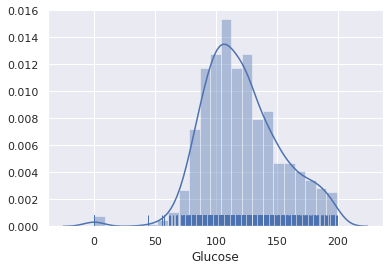

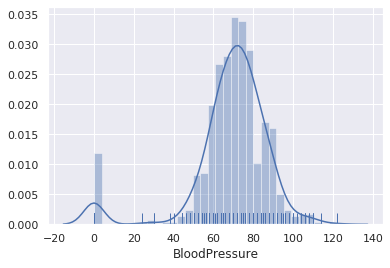

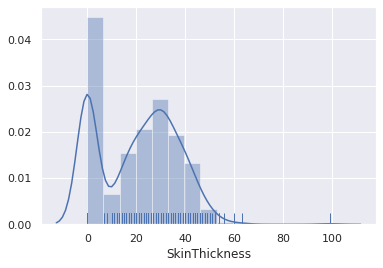

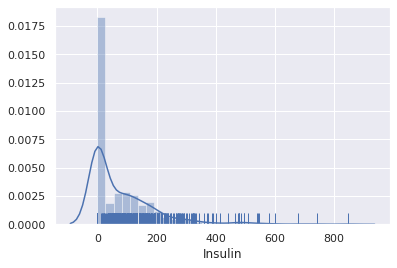

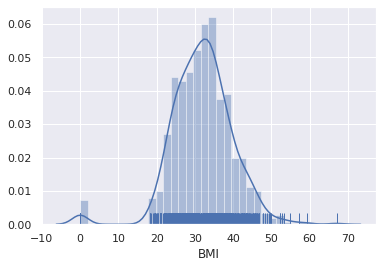

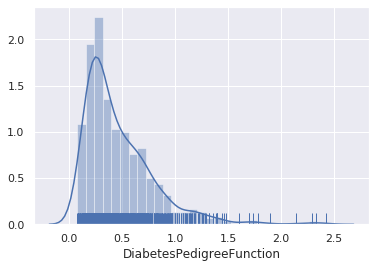

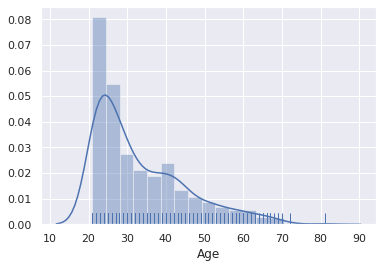

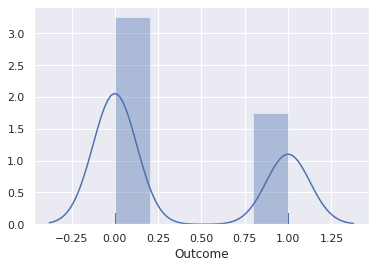

In [20]:
for column in diabetes.columns:
    sns.distplot(diabetes[column], rug=True)
    plt.show()

The plots show spikes in histograms at value 0 for `Glucose`, `BloodPressure`, `SkinThickness`, `Insuline`, and `BMI` features. Based on the domain knowledge, these values are highly suspicious. People with no blood pressure, glucose in blood, nor skin would be pretty much dead. As it turns out, those are in fact missing values encoded as zeros (there have been later papers point this out).

As a side note, we can try our Grubbs' test, for example, on `Glucose` feature.

In [21]:
grubbs_outliers(diabetes.Glucose)

Series([], Name: Glucose, dtype: int64)

It did not spot any outliers. This is because of the masking as discussed above. Note: There is also `SkinThickness` value of 99 mm which is well above the rest of the observation. It could also be an error in the measurement and this value is actually detected by Grubbs' test.

<div class="alert alert-block alert-warning"><b>Exercise 4</b></div>

Replace all zeros in columns `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI` with `np.nan` values.

In [22]:
# TODO: your code goes here...
diabetes.Glucose.replace(0, np.nan, inplace=True)
diabetes.BloodPressure.replace(0, np.nan, inplace=True)
diabetes.SkinThickness.replace(0, np.nan, inplace=True)
diabetes.Insulin.replace(0, np.nan, inplace=True)
diabetes.BMI.replace(0, np.nan, inplace=True)

Now we have two possibilities what to do with missing values.
1. Throw away the whole observation.
2. Impute the missing values.

Since we would like to find outliers in the data the imperfect imputation could introduce new outliers. Therefore, let's just throw away the incomplete observation.

In [23]:
diabetes.dropna(inplace=True)
diabetes.reset_index(drop=True, inplace=True)

In [24]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               392 non-null    int64  
 1   Glucose                   392 non-null    float64
 2   BloodPressure             392 non-null    float64
 3   SkinThickness             392 non-null    float64
 4   Insulin                   392 non-null    float64
 5   BMI                       392 non-null    float64
 6   DiabetesPedigreeFunction  392 non-null    float64
 7   Age                       392 non-null    int64  
 8   Outcome                   392 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 27.7 KB


We are still left with 392 observation.

### Local Outlier Factor (LOF)

The basic idea is that outliers are data points with different density around them than the densities around their nearest neighbors. The bigger the difference the more likely it is an outlier. You can read a more elaborate explanation in [scikit-learn user guide](https://scikit-learn.org/stable/modules/outlier_detection.html#local-outlier-factor) and the formulas for computation are in the slides for lecture 4.

<div class="alert alert-block alert-warning"><b>Exercise 5</b></div>

Find outliers in `diabetes` dataset using [LocalOutlierFactor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#) detector. LOF uses distances between points similarly to KNN therefore do not forget to **scale data appropriately**. Variable `outliers` will contain numpy array with 392 boolean values, one for every observation, indicating whether the observation is an outlier or not.

In [31]:
# TODO: your code goes here...
# outliers = ...
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

pipeline = make_pipeline(
    MinMaxScaler(),
    LocalOutlierFactor()
)

outliers = pipeline.fit_predict(diabetes) == -1

array([False,  True, False, False,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False,

Now let's add a new column to `diabetes` and inspect what makes them outliers.

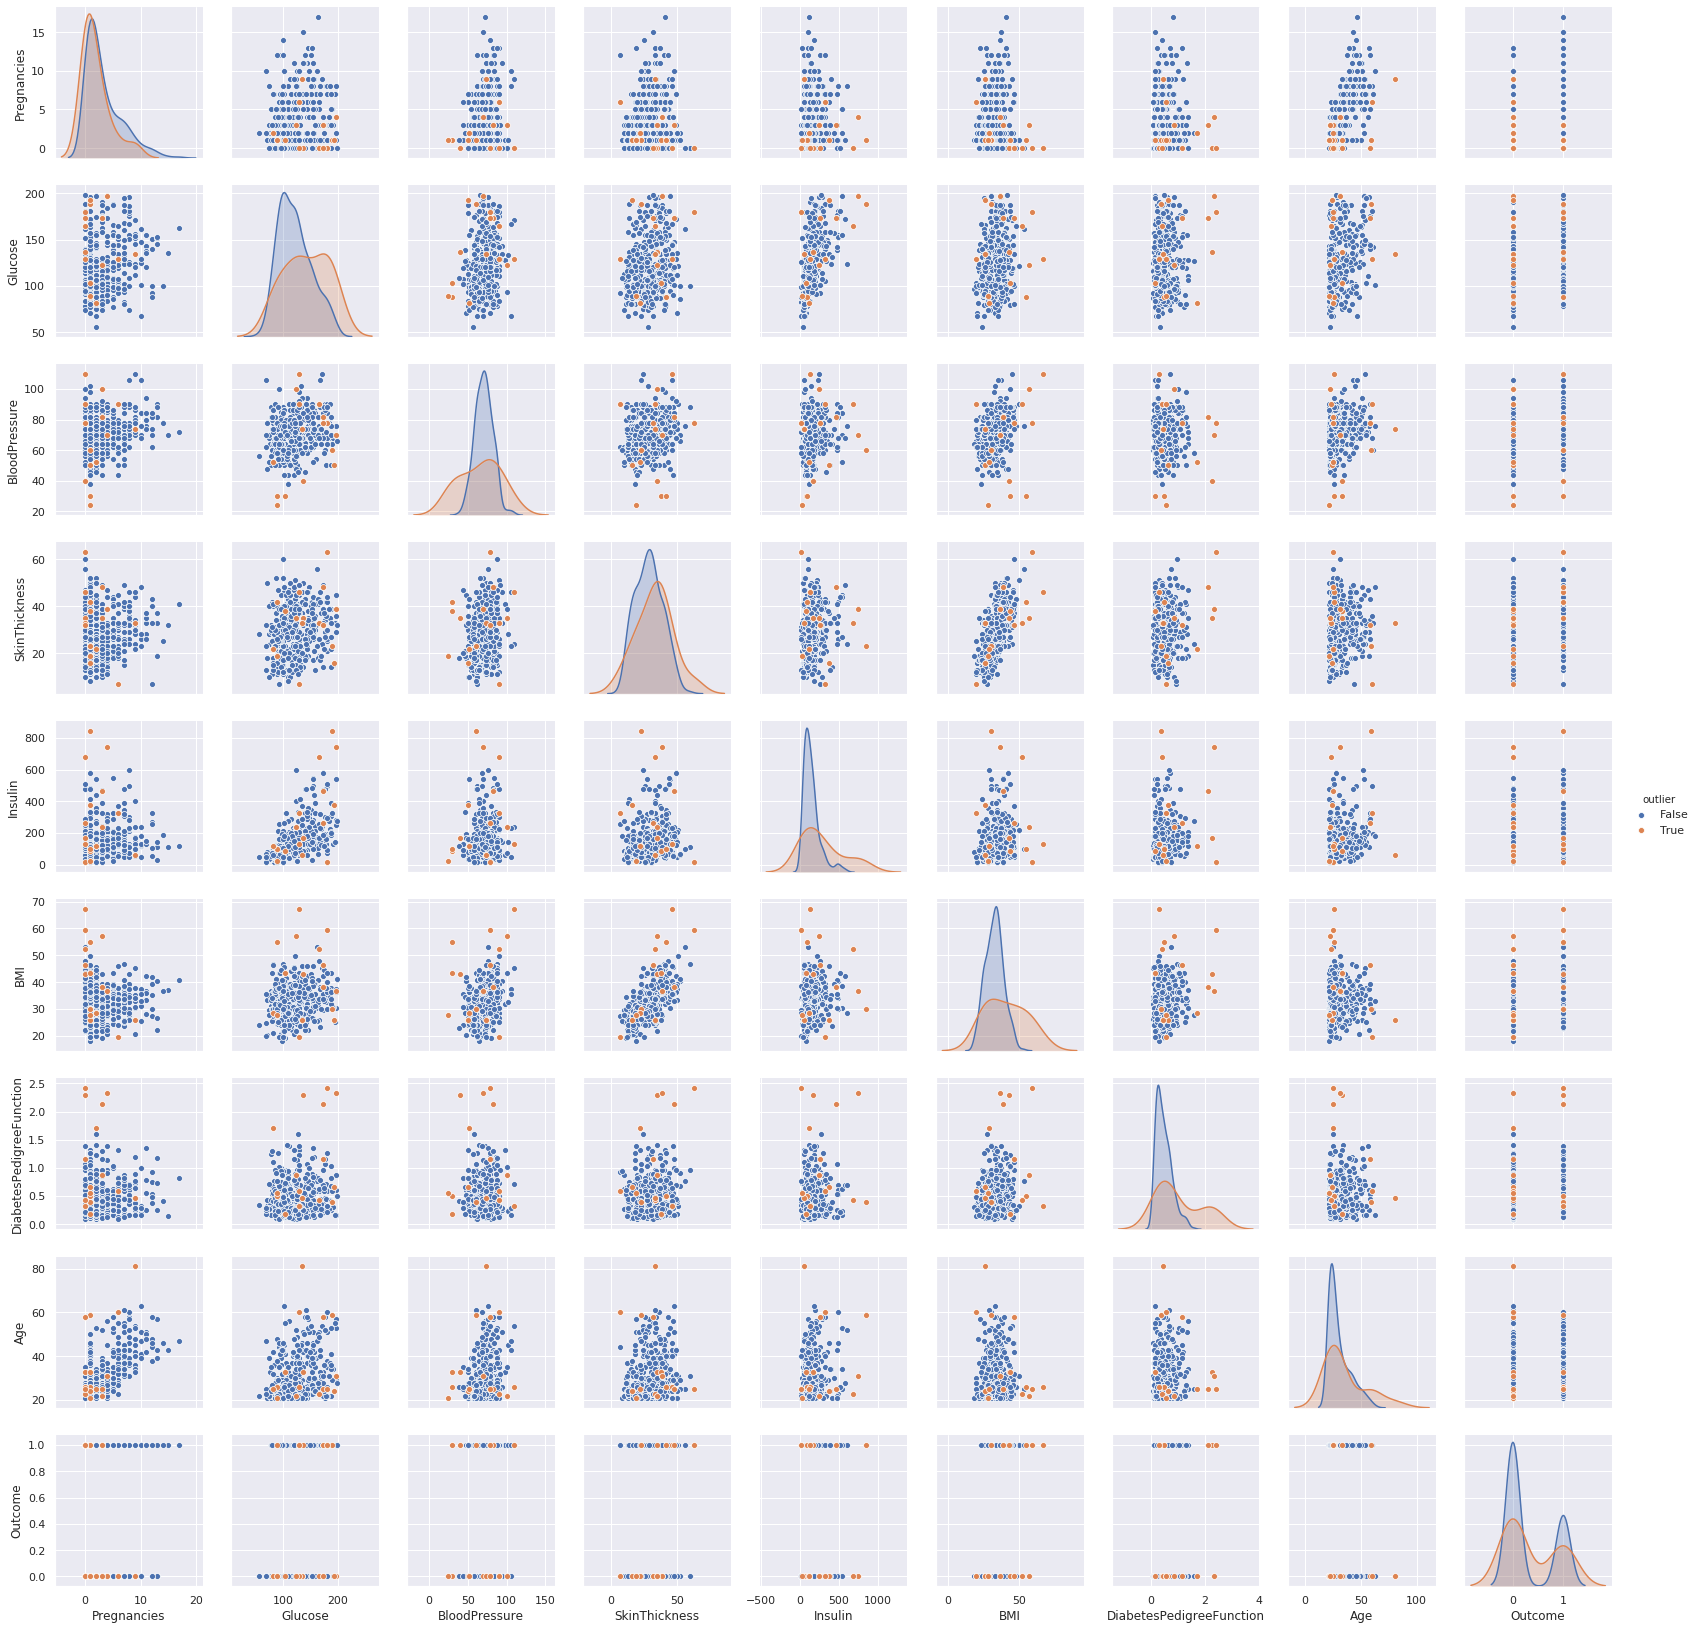

In [32]:
diabetes["outlier"] = pd.Series(outliers)
sns.pairplot(data=diabetes, hue="outlier")

Can you identify any feature or combination of features that makes these observations outliers? There is no clear and definitive answer but you could identify some features or combination of features that have more outliers outside the main "cloud" of points.

### Isolation Forest

Isolation forest is another common method for identifying outliers. The basic idea is that outliers are easier to separate from the rest of the data by making random 'cut' along randomly selected feature. This essentially builds a decision tree that partitions the feature space. Outliers tend to need less splits (they take shorter paths in the tree) then normal data. These path lengths are average across many different trees (forest) that make up what is called ensemble model. We will look at ensembles in some future tutorial.

<div class="alert alert-block alert-warning"><b>Exercise 6</b></div>

Find outliers in `diabetes` dataset using [IsoloationForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#) detector. Do not forget to **remove `outlier` column**. Use [Jaccard similarity coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html#) to asses the agreement between outliers found by LOF and isolation forest. Note the isolation forest uses randomness and each run might result in different outliers being found. Run the computation a few times to get better estimate of the expected value of the Jaccard coefficient. it should be around 0.24 ± 0.03.

In [40]:
# TODO: you code goes here...
from sklearn.ensemble import IsolationForest
from sklearn.metrics import jaccard_score

pipeline2 = make_pipeline(
    MinMaxScaler(),
    IsolationForest()
)

outliers2 = pipeline2.fit_predict(diabetes.drop(columns="outlier")) == -1
jaccard_score(outliers, outliers2)

0.2641509433962264